# Machine Learning in Python - Group Project 2

**Due Friday, April 14th by 16.00 pm.**

*Elliot Leishman, William Jones, Tristan Pang, Aidan Garrity * 

(Group 15)

# Head of state's message: 

Some things we want to include: 
 - Some discussion of the features that are most important for predicting a cancellation - we do not
need discussion of specific coefficient values but direction of the effect should be clear (e.g. the
earlier a booking is made the more likely it is to be canceled).

 - A validated assessment of your model’s performance, but this must be specifically discussed in the
context of bookings and running a hotel.

 - It is not sufficient to report summary statistics like the accuracy or AUC - you must address the
performance in terms of potential gains and losses for the hotel (e.g. think about what happens if
your model predicts a cancellation that does not actually occur and a room ends up being double
booked or vice versa).

 - Explain why you think your particular model would or would not be economically viable


# Supreme Leader of the Ministry of Theory's Message

Classification task

Obviously we want a model with a low FPR and FNR. But we care most about lowering FPR, since having a room double booked is worse then having a room booking cancelled. Double bookings could result in financial losses, bad reviews and lawsuits, I guess?

4 most obvious classification strategies:
 - Logistic Regression
 - Support Vector Machines
 - Decision Trees
 - Neural Networks

Do we want to stratify our test-train split for resort and city hotel?

Ways to compare classification models:
 - Confusion Matrices
 - ROC curves & AUC
 - Accuracy
 - F1 score

## General Setup

In [34]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [2]:
# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

In [3]:
# Load data
d = pd.read_csv("hotel.csv")

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client).* 

- If you use any additional data sources, you should introduce them here and discuss why they were included.

- Briefly outline the approaches being used and the conclusions that you are able to draw.

In [4]:
display(d)

,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,0,Resort Hotel,342,2015,July,27,1,0,0,2,...,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0
1,0,Resort Hotel,737,2015,July,27,1,0,0,2,...,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0
2,0,Resort Hotel,7,2015,July,27,1,0,1,1,...,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0
3,0,Resort Hotel,13,2015,July,27,1,0,1,1,...,A,0,No Deposit,304.0,NaN,0,Transient,75.00,0,0
4,0,Resort Hotel,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,City Hotel,23,2017,August,35,30,2,5,2,...,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0
119386,0,City Hotel,102,2017,August,35,31,2,5,3,...,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2
119387,0,City Hotel,34,2017,August,35,31,2,5,2,...,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4
119388,0,City Hotel,109,2017,August,35,31,2,5,2,...,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0


## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling.* 

- Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. 
- Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data.*

- Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. 
- Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

**All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.**

### 2.1 Data Cleaning 

In [5]:
d.dtypes

is_canceled                         int64
hotel                              object
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [6]:
# get columns which have NaN values 
cols_with_nan = d.columns[d.isna().any()].tolist()
print('NaN Columns: ', cols_with_nan)

# find out how many NaN values are in those columns
for col in cols_with_nan:
    print(f"Column '{col}' contains {d[col].isna().sum()} NaN values.")

NaN Columns:  ['children', 'country', 'agent', 'company']
Column 'children' contains 4 NaN values.
Column 'country' contains 488 NaN values.
Column 'agent' contains 16340 NaN values.
Column 'company' contains 112593 NaN values.


In [7]:
# drop rows which have NaN values in 'children' and 'country' columns. 
df = d.dropna(subset=['children', 'country'])

# fill the remaining NaN values to be zero
df = df.fillna(0)


In [8]:
# Delete duplicate rows. Note 32215 rows are duplicated rows to delete
df.drop_duplicates(keep='first', inplace=True)


#### 2.2 Data Encoding 


In [9]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

le_dict = defaultdict(LabelEncoder)

# apply label encoder to all columns
encoded_df = df.apply(lambda x: le_dict[x.name].fit_transform(x))

# inverse label encoder, for later use 
df = encoded_df.apply(lambda x: le_dict[x.name].inverse_transform(x))

# https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
encoded_df


,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,0,1,342,0,5,26,0,0,0,2,...,2,3,0,0,0,0,2,1,0,0
1,0,1,478,0,5,26,0,0,0,2,...,2,4,0,0,0,0,2,1,0,0
2,0,1,7,0,5,26,0,0,1,1,...,2,0,0,0,0,0,2,2129,0,0
3,0,1,13,0,5,26,0,0,1,1,...,0,0,0,221,0,0,2,2129,0,0
4,0,1,14,0,5,26,0,0,2,2,...,0,0,0,174,0,0,2,3528,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,0,23,2,1,34,29,2,5,2,...,0,0,0,272,0,0,2,3430,0,0
119386,0,0,102,2,1,34,30,2,5,3,...,4,0,0,9,0,0,2,8119,0,2
119387,0,0,34,2,1,34,30,2,5,2,...,3,0,0,9,0,0,2,6398,0,4
119388,0,0,109,2,1,34,30,2,5,2,...,0,0,0,78,0,0,2,3914,0,0


#### 2.3 Feature Investigation

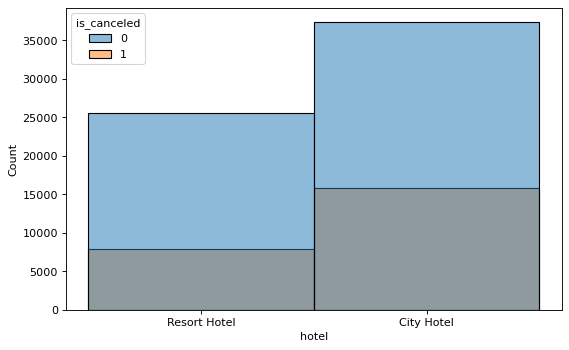

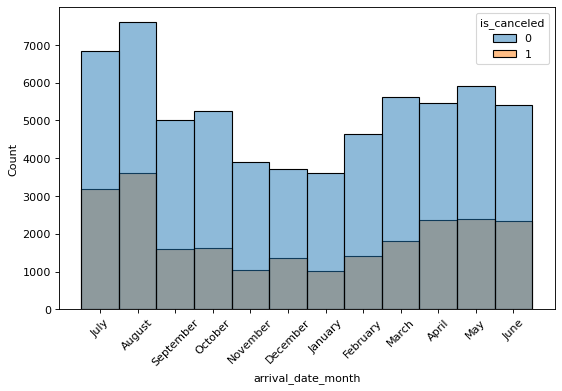

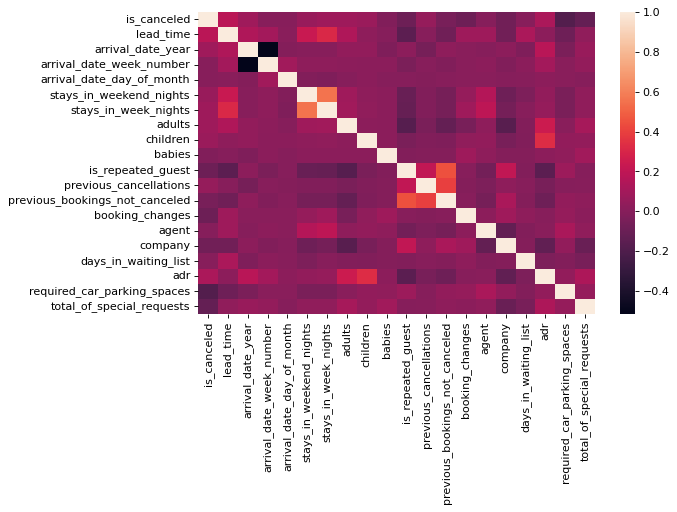

In [10]:
plt.figure()
sns.histplot(data = df, x = 'hotel', hue = 'is_canceled')
plt.show()

plt.figure()
sns.histplot(data = df, x = 'arrival_date_month', hue = 'is_canceled')
plt.xticks(rotation = 45)
plt.show()

corr = df.corr()
plt.figure()
sns.heatmap(corr)
plt.show()

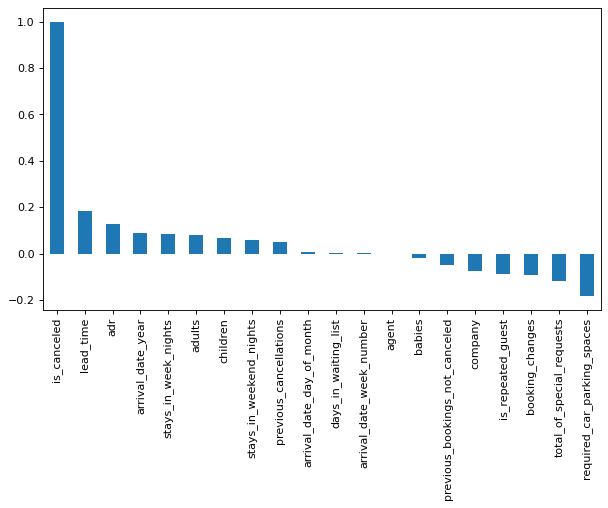

In [11]:
fig, ax = plt.subplots(figsize=(9,5))
df.corr()["is_canceled"].sort_values(ascending=False).plot(kind="bar", ax=ax)
plt.show()

## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model.*

- You are strongly encouraged to explore many different modeling methods (e.g. logistic regression, classification trees, SVC, etc.) but you should not include a detailed narrative of all of these attempts. 
- At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.

*For example if you considered a logistic regression model, a classification tree, and a SVC model and ultimately settled on the logistic regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the logistic regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

**This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.**

In [ ]:
# Model Evaluation Function

def eval(true, pred, confusion=True, AUC = True, ROCplot=True):
    if confusion:
        print('Confusion Matrix: \n', sklearn.metrics.confusion_matrix(true,pred))
    if AUC:
        print('AUC: ', sklearn.metrics.roc_auc_score(true,pred))
    if ROCplot:
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(true, pred)
        # calculate AUC score
        roc_auc = sklearn.metrics.auc(fpr, tpr)

        # plot ROC curve
        plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()


#### Data Formatting

In [19]:
from sklearn.model_selection import train_test_split

X = encoded_df.drop('is_canceled', axis = 1)
y =encoded_df['is_canceled']

# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Logistic Regression 

Log-reg R-squared score:  -0.3856979077030831
Log-reg Accuracy:  0.7261295904633724
Confusion Matrix: 
 [[18267   686]
 [ 6436   616]]
AUC:  0.5255781542059186


/Users/aidangarrity/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


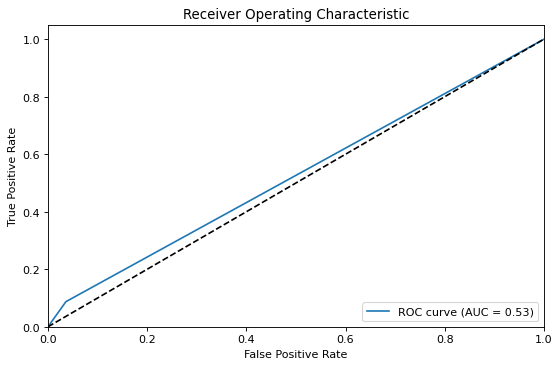

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

# create a logistic regression model
logreg = LogisticRegression()

# fit the model to the data
logreg.fit(X_train, y_train)

# predict using logistic regression 
y_pred = logreg.predict(X_test)

r2 = r2_score(y_test, y_pred)
print('Log-reg R-squared score: ', r2)

accuracy = accuracy_score(y_test, y_pred)
print('Log-reg Accuracy: ', accuracy)

eval(y_test, y_pred)

In [14]:
from sklearn.linear_model import LogisticRegressionCV
# Logistic regression: try lasso, ridge, elasticnet, backwards and forwards
# Add in cross validation later
lr_lasso = LogisticRegression(penalty='l1', solver = 'saga', max_iter = 10000)
lr_lasso.fit(X_train, y_train)



LogisticRegression(max_iter=10000, penalty='l1', solver='saga')

#### SVC

In [15]:
# from sklearn.svm import SVC

# # create a logistic regression model
# svc = SVC()

# # fit the model to the data
# svc.fit(X_train, y_train)

# # predict using logistic regression 
# y_pred = svc.predict(X_test)

# r2 = r2_score(y_test, y_pred)
# print('SVC R-squared score: ', r2)

# accuracy = accuracy_score(y_test, y_pred)
# print('SVC Accuracy: ', accuracy)



#### SVM

Linear SVM Accuracy: 0.7343972313016728
0.1
Confusion Matrix: 
 [[18890    63]
 [ 6844   208]]
AUC:  0.5130855833214796


/Users/aidangarrity/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


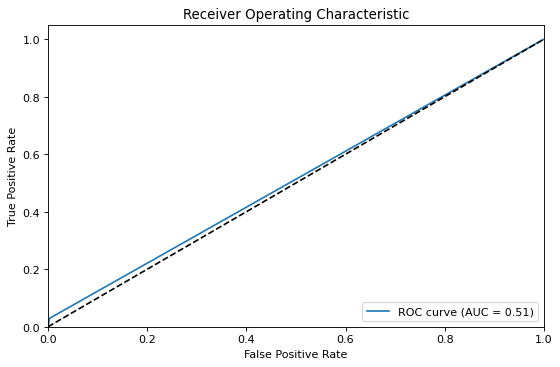

Linear SVM Accuracy: 0.45395116323783885
0.5
Confusion Matrix: 
 [[ 5498 13455]
 [  745  6307]]
AUC:  0.5922211066099893


/Users/aidangarrity/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


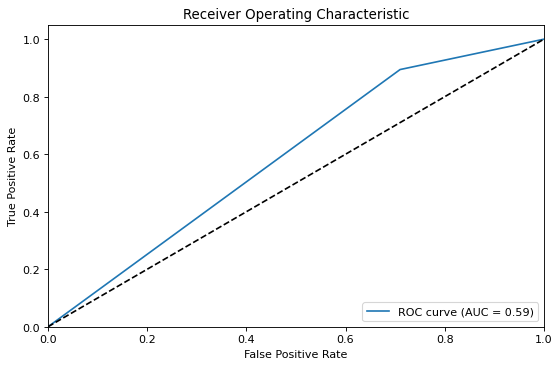

Linear SVM Accuracy: 0.5318208036915978
1
Confusion Matrix: 
 [[ 8672 10281]
 [ 1894  5158]]
AUC:  0.5944883017934414


/Users/aidangarrity/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


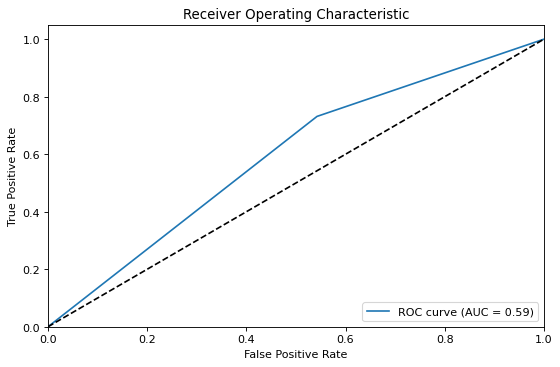

Linear SVM Accuracy: 0.7346279561622765
5
Confusion Matrix: 
 [[18866    87]
 [ 6814   238]]
AUC:  0.5145794943272367


/Users/aidangarrity/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


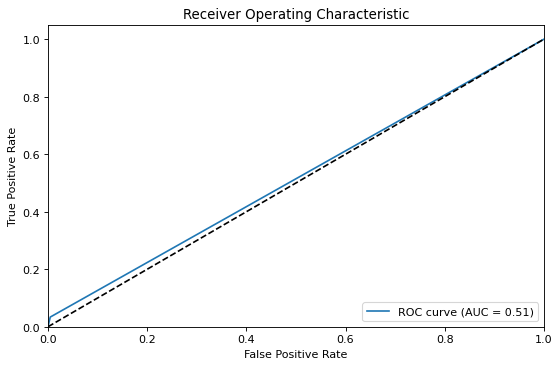

Linear SVM Accuracy: 0.33920399923091715
10
Confusion Matrix: 
 [[ 1847 17106]
 [   78  6974]]
AUC:  0.5431954493874583


/Users/aidangarrity/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


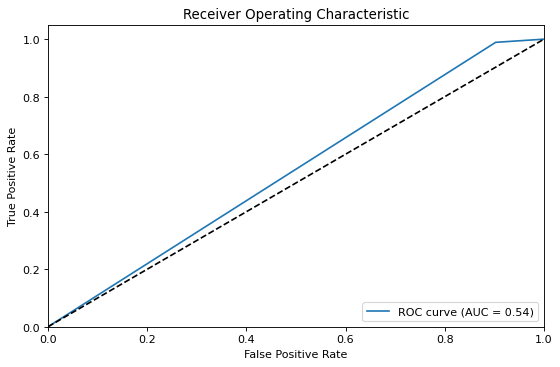

In [32]:
from sklearn.svm import SVC, LinearSVC

for C in [0.1,0.5,1,5,10]:
    clf = LinearSVC(C=C)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print("Linear SVM Accuracy:", accuracy)

    print(C)
    eval(y_test, y_pred)

# clf = SVC(kernel='poly')

# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Polynommial Accuracy:", accuracy)

# clf = SVC(kernel='rbf')

# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("RBF Accuracy:", accuracy)

# clf = SVC(kernel='sigmoid')

# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Sigmoid Accuracy:", accuracy)

#### Random Fores

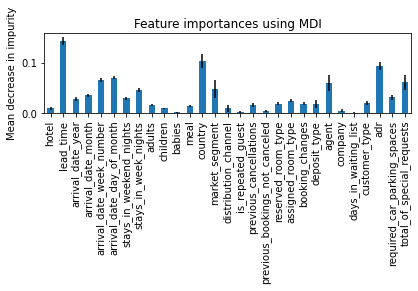

Confusion Matrix: 
 [[17582  1371]
 [ 2547  4505]]
AUC:  0.7832445158919102


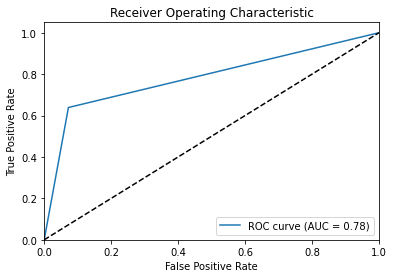

In [41]:
from sklearn.ensemble import RandomForestClassifier

# Create random forest classifier object
# increasing n_estimators to 500 increases runtime withoug meaningfully increasing AUC
# oob_score does not improve model
rf = RandomForestClassifier(n_estimators=100)

# Train the classifier on the training data
rf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf.predict(X_test)

# Code from scikit learn documentation
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()


eval(y_test, y_pred)


## 4. Discussion & Conclusions


*In this section you should provide a general overview of **your final model**, its **performance**, and **reliability**.* 

Your report must include the following:

* Some discussion of the features that are most important for predicting a cancelation - we do not need discussion of specific coefficient values but direction of the effect should be clear (e.g. the earlier a booking is made the more likely it is to be canceled).

* A validated assessment of your model's performance, but this must be specifically discussed in the context of bookings and running a hotel. 

* It is not sufficient to report summary statistics like the accuracy or AUC - you must address the perfomance in terms of potential gains and losses for the hotel (e.g. think about what happens if your model predicts a cancelation that does not actually occur and a room ends up being double booked or vice versa). 

* Explain why you think your particular model would or would not be economically viable.

## 5. References

*In this section, you should present a list of external sources (except the course materials) that you used during the project, if any*

- Additional data sources can be cited here, in addition to related python documentations, any other webpage sources that you benefited from